# Notebook Title

[Feature Engineering](#Feature Engineering)

[Visualizing data](#Visualizing Data)

[Principal Component Analysis](#Principal Component Analysis)

[Modeling Data](#Modeling Data)

[Model Validation](#Model Validation)

## Feature Engineering

<a id='Feature Engineering'></a>

In [1]:
import numpy as np#Math library
import pandas as pd#Table library
import matplotlib.pyplot as plt#Plotting library
import pandas as pd
import warnings
import seaborn as sns#Plotting library
warnings.filterwarnings('ignore')#Gets rid of popup warnings
%matplotlib nbagg

In [19]:
data= pd.read_csv('Consumer_Complaints_Search_Overdraft.csv')
data.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,11/24/2014,Prepaid card,Other special purpose card,"Overdraft, savings or rewards features",NaN,NaN,NaN,Citibank,FL,33612,NaN,NaN,Phone,12/01/2014,Closed with monetary relief,Yes,Yes,1129509
1,11/25/2014,Prepaid card,General purpose card,"Overdraft, savings or rewards features",NaN,NaN,NaN,"NetSpend Corporation, a TSYS Company",CA,90018,Older American,NaN,Web,12/03/2014,Closed with explanation,Yes,No,1131773
2,03/24/2015,Payday loan,Payday loan,Can't stop charges to bank account,Can't stop charges to bank account,"I took out a Loan from Cash Central XXXX, Al f...",Company chooses not to provide a public response,"Community Choice Financial, Inc.",AL,351XX,Older American,Consent provided,Web,03/24/2015,Closed with explanation,Yes,No,1299258


In [21]:
data.shape

(2190, 18)

Since 'Consumer complaint narrative' is really and can be expected to sway banks' responses, let's make a new feature that counts the number of words as a feature. Let's also group states by a  [region](http://www.census.gov/econ/census/help/geography/regions_and_divisions.html "link") of the country to limit the number of features we hot-encode.

In [85]:
data['consumer_narr_word_len'] = data['Consumer complaint narrative'].map(lambda x: len((str(x)).split()))

In [98]:
#Define regions
northeast = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY','PA'] 
midwest = ['IL', 'IN', 'MI', 'OH', 'WI','IA', 'KS', 'MN', 'MO', 
           'NE', 'ND', 'SD']
south = ['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'AL', 
         'KY', 'MS', 'TN', 'AR', 'LA', 'OK','TX']
west = ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 
        'HI', 'OR', 'WA']

#Initialize state and region lists
state= data['State'].values
region= []

#Assign regions to state
for i in state:
    if i in northeast: region.append('northeast')
    elif i in midwest: region.append('midwest')
    elif i in south: region.append('south')
    elif i in west: region.append('west')
    else: region.append(None)

#Make region new column in dataframe
data['region']= region

In [99]:
data['region'].unique()

array(['south', 'west', 'northeast', 'midwest', None], dtype=object)

Now that we have these, let's see what columns we'll keep in our analysis, which columns we'll turn into dummy variables and which columns will just be dropped out altogether.

In [100]:
names= list(data.columns)

In [102]:
#Counts unique entries for each column
for i in range(0,len(names)):
    print names[i], ': ', len(data[names[i]].unique())

Date received :  549
Product :  11
Sub-product :  36
Issue :  65
Sub-issue :  36
Consumer complaint narrative :  2158
Company public response :  10
Company :  172
State :  54
ZIP code :  550
Tags :  4
Consumer consent provided? :  3
Submitted via :  3
Date sent to company :  541
Company response to consumer :  5
Timely response? :  2
Consumer disputed? :  3
Complaint ID :  2190
consumer_narr_word_len :  642
region :  5


We determined that 'Consumer Narr' was too long and summarized it with a word count so we can eliminate it now. We'll also delete the dates cause they can be summarized by 'Timely response', and 'State' and 'Zip code' cause we now have region information. 'Sub-issue' only appears for a fraction of our data so we'll remove it too. For the remaining columns, we'll keep them if they're continuous or one-hot encode their responses as additional columns (expect ~200).

colums to eliminate: Date received, Sub-issue, Consumer complaint narrative, State,
    Zip code, Date sent to company, Compaind ID

In [127]:
dataClean= data.copy()
dataClean= dataClean.drop(['Date received', 'Sub-product','Sub-issue', 'Consumer complaint narrative',
          'State', 'ZIP code', 'Date sent to company', 'Complaint ID', 
          'consumer_narr_word_len'], axis=1)
        
#We'll also remove the Complaint ID	consumer_narr_word_len since those are continuous
#(we'll append these to our final table later)

## Formatting Data

<a id='Formatting Data'></a>

In [128]:
dataClean.head(3)

,Product,Issue,Company public response,Company,Tags,Consumer consent provided?,Submitted via,Company response to consumer,Timely response?,Consumer disputed?,region
0,Prepaid card,"Overdraft, savings or rewards features",NaN,Citibank,NaN,NaN,Phone,Closed with monetary relief,Yes,Yes,south
1,Prepaid card,"Overdraft, savings or rewards features",NaN,"NetSpend Corporation, a TSYS Company",Older American,NaN,Web,Closed with explanation,Yes,No,west
2,Payday loan,Can't stop charges to bank account,Company chooses not to provide a public response,"Community Choice Financial, Inc.",Older American,Consent provided,Web,Closed with explanation,Yes,No,south


Ok if we decide to one-hot decode our data, we'll find that we'll have one 'Nan' or null column per feature. Since our data is categorical we can't imput these based on a media value, but it's not useful to include these in our dataset. That said after one-hot encoding the data, we'll be able to remove these as features at that stage.

In [218]:
dataClean2= dataClean.copy()
columns= dataClean2.columns

for i in range(0, len(columns)):
    
    for elem in dataClean2[columns[i]].unique():
        dataClean2[str(elem)] = dataClean2[columns[i]] == elem
dataClean2.head(3)

,Product,Issue,Company public response,Company,Tags,Consumer consent provided?,Submitted via,Company response to consumer,Timely response?,Consumer disputed?,...,Closed with non-monetary relief,Closed,Untimely response,Yes,No,south,west,northeast,midwest,None
0,Prepaid card,"Overdraft, savings or rewards features",NaN,Citibank,NaN,NaN,Phone,Closed with monetary relief,Yes,Yes,...,False,False,False,True,False,True,False,False,False,False
1,Prepaid card,"Overdraft, savings or rewards features",NaN,"NetSpend Corporation, a TSYS Company",Older American,NaN,Web,Closed with explanation,Yes,No,...,False,False,False,False,True,False,True,False,False,False
2,Payday loan,Can't stop charges to bank account,Company chooses not to provide a public response,"Community Choice Financial, Inc.",Older American,Consent provided,Web,Closed with explanation,Yes,No,...,False,False,False,False,True,True,False,False,False,False


In [219]:
print dataClean.shape, dataClean2.shape

(2190, 11) (2190, 289)


In [220]:
newColumns= dataClean2.columns
for i in range(0,len(newColumns)):
    print newColumns[i], ': ', len(dataClean2[newColumns[i]].unique())

Product :  11
Issue :  65
Company public response :  10
Company :  172
Tags :  4
Consumer consent provided? :  3
Submitted via :  3
Company response to consumer :  5
Timely response? :  2
Consumer disputed? :  3
region :  5
Prepaid card :  2
Payday loan :  2
Bank account or service :  2
Credit card :  2
Debt collection :  2
Mortgage :  2
Consumer Loan :  2
Student loan :  2
Credit reporting :  2
Money transfers :  2
Other financial service :  2
Overdraft, savings or rewards features :  2
Can't stop charges to bank account :  2
Problems caused by my funds being low :  2
Deposits and withdrawals :  2
Making/receiving payments, sending money :  2
Delinquent account :  2
Account opening, closing, or management :  2
False statements or representation :  2
Loan servicing, payments, escrow account :  2
Managing the loan or lease :  2
APR or interest rate :  2
Dealing with my lender or servicer :  2
Loan modification,collection,foreclosure :  2
Advertising and marketing :  2
Billing disputes :

Awesome! Now we have ~280 features instead of 11 but our categorical data is now encoded into binary values. As a final step, let's eliminate the columns that the binary data came from to avoid having correlated features and let's append the continuous columns back into our dataframe.

In [221]:
#Remove source columns for one hot encoding
dataClean2= dataClean2.drop(['Product','Issue','Company public response',
                             'Company','Tags', 'Consumer consent provided?', 
                            'Submitted via', 'region', 'Company response to consumer', 'None'],axis= 1)
#Add back 'Complaint ID' and'consumer_narr_word_len'
dataClean2['Complaint ID']= data['Complaint ID']
dataClean2['Consumer_narr_word_len']= data['consumer_narr_word_len']

#Replace 'Yes' and 'No' with True and False

dataClean2= dataClean2.replace(['Yes', 'No'], [1, 0])
dataClean2= dataClean2.replace([np.inf, -(np.inf)], np.nan)

#Now we'll get the column names again and we'll fill nans in with mode

dataClean2Cols= dataClean2.columns
for i in dataClean2Cols:
    if dataClean2[i].dtype == bool:
        dataClean2[i]= dataClean2[i].fillna(dataClean2[i].mode)
    else:
        dataClean2[i]= dataClean2[i].fillna(dataClean2[i].median)

#Finally, I'll convert my 'Consumer disputed' feature from a 'object' type
#into a boolean type so it can play well with sklearn
dataClean2['Consumer disputed?']= dataClean2['Consumer disputed?'].astype(np.bool)

dataClean2.head(3)

,Timely response?,Consumer disputed?,Prepaid card,Payday loan,Bank account or service,Credit card,Debt collection,Mortgage,Consumer Loan,Student loan,...,Closed,Untimely response,Yes,No,south,west,northeast,midwest,Complaint ID,Consumer_narr_word_len
0,1,1,True,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,1129509,1
1,1,0,True,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,1131773,1
2,1,0,False,True,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,1299258,652


## Principal Component Analysis

<a id='Principal Component Analysis'></a>

Before doing anything else, I'll separate my features from the one column that I think would be most likely to be a target variable: 'Closed with monetary relief'

In [235]:
features= dataClean2.ix[:, dataClean2.columns != 'Closed with monetary relief']

In [236]:
from sklearn import preprocessing
from sklearn import decomposition

featsScaled= preprocessing.scale(features)
pca = decomposition.PCA(n_components=0.9)
pca.fit(featsScaled)
pcaFeats = pca.transform(featsScaled)

In [289]:
dataClean2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Columns: 281 entries, Timely response? to Consumer_narr_word_len
dtypes: bool(278), int64(3)
memory usage: 645.9 KB


<IPython.core.display.Javascript object>


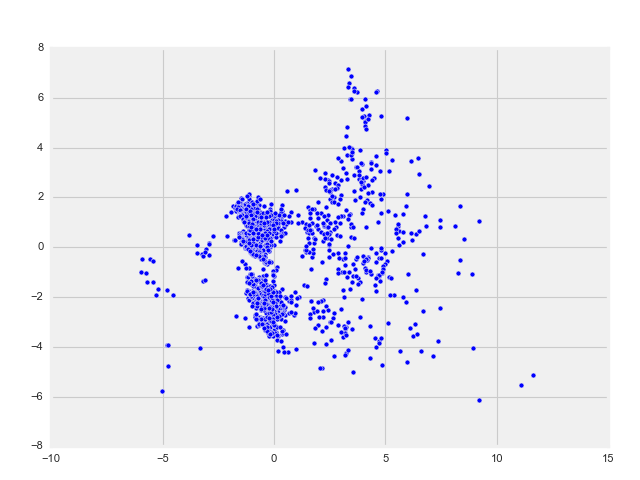

In [284]:
plt.scatter(pcaFeats[:,1],pcaFeats[:,2])

In [296]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=10).fit(pcaFeats)

In [297]:
cluster0= []; indexCluster0= []
cluster1= []; indexCluster1= []
cluster2= []; indexCluster2= []

for i in range(0,len(db.labels_)):
    if db.labels_[i] == -1: 
        cluster0.append(pcaFeats[i,:])
        indexCluster0.append(i)
    elif db.labels_[i] == 0: 
        cluster1.append(pcaFeats[i,:])
        indexCluster1.append(i)
    elif db.labels_[i] == 1: 
        cluster2.append(pcaFeats[i,:])
        indexCluster2.append(i)

In [299]:
set(db.labels_)

{-1, 0, 1, 2, 3, 4, 5}

<IPython.core.display.Javascript object>


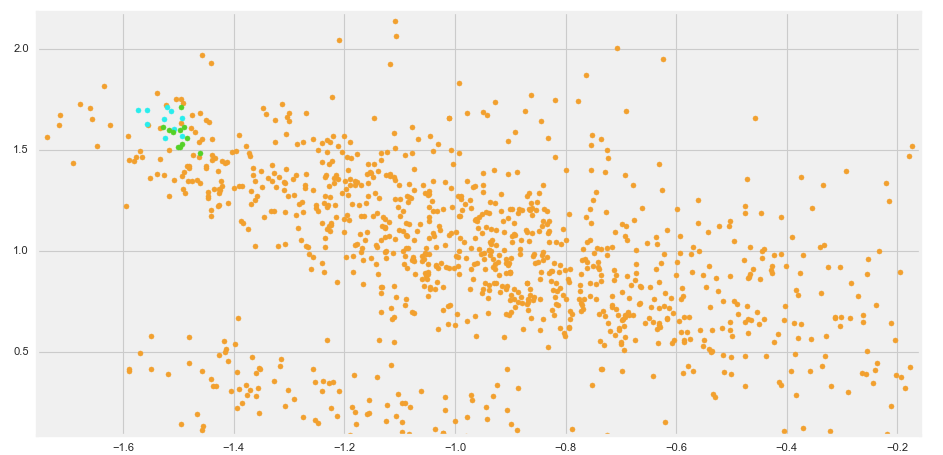

In [293]:
cluster0= np.array(cluster0)
cluster1= np.array(cluster1)
cluster2= np.array(cluster2)

clusters= [cluster0, cluster1, cluster2]
#scales= [win_pctg, total_wins, total_goals_for, chanceCreationCrossing]
titles= ['Team Clusters Scaled by Win %', 'Team Clusters Scaled by Total Wins',
         'Team Clusters Scaled by Total Goals', 'Team Clusters Scaled by Crosses']


#plotIndices= [[2,2,1],[2,2,2],[2,2,3],[2,2,4]]

figure, ax = plt.subplots(1,1, figsize=(12,10))

plt.scatter(cluster0[:,1], cluster0[:,2], color= '#f2a02e')
plt.scatter(cluster1[:,1], cluster1[:,2], color= '#28eded')
plt.scatter(cluster2[:,1], cluster2[:,2], color= '#54d127')



# for i in range(4):
#     plt.style.use('fivethirtyeight')
#     plt.subplot(2, 2, i+1)
#     plt.scatter(pcaFeats[:,0], pcaFeats[:,1])
#     plt.xlabel('PC1')
#     plt.ylabel('PC2')

#     plt.scatter(cluster0[:,0], cluster0[:,1], color= '#f2a02e')#, s= scales[i][indexCluster0]*8, alpha= 0.2) 
#     plt.scatter(cluster1[:,0], cluster1[:,1], color= '#28eded')#, s= scales[i][indexCluster1]*8, alpha= 0.2)
#     plt.scatter(cluster2[:,0], cluster2[:,1], color= '#54d127')#, s= scales[i][indexCluster2]*8, alpha= 0.2)
    
#     plt.title(titles[i], fontweight= 'bold')
plt.tight_layout()

## Formatting Data

<a id='Formatting Data'></a>

## Formatting Data

<a id='Formatting Data'></a>

In [329]:
data.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,consumer_narr_word_len,region
0,11/24/2014,Prepaid card,Other special purpose card,"Overdraft, savings or rewards features",NaN,NaN,NaN,Citibank,FL,33612,NaN,NaN,Phone,12/01/2014,Closed with monetary relief,Yes,Yes,1129509,1,south
1,11/25/2014,Prepaid card,General purpose card,"Overdraft, savings or rewards features",NaN,NaN,NaN,"NetSpend Corporation, a TSYS Company",CA,90018,Older American,NaN,Web,12/03/2014,Closed with explanation,Yes,No,1131773,1,west
2,03/24/2015,Payday loan,Payday loan,Can't stop charges to bank account,Can't stop charges to bank account,"I took out a Loan from Cash Central XXXX, Al f...",Company chooses not to provide a public response,"Community Choice Financial, Inc.",AL,351XX,Older American,Consent provided,Web,03/24/2015,Closed with explanation,Yes,No,1299258,652,south


In [333]:
stateMonetary = data[data['Company response to consumer']== 'Closed with monetary relief']
stateNotMonetary= data[data['Company response to consumer']!= 'Closed with monetary relief']


#data[data['Company response to consumer'] != 'Closed with monetary relief'].count()
#data['State'].value_counts().plot(kind='bar')
#sns.barplot(x= data['Submitted via'].sum(), y= 'Submitted via', data= data)

In [342]:
sumMonetary= stateMonetary.groupby(['State']).agg('count')
sumNotMonetary= stateNotMonetary.groupby(['State']).agg('count')

proportionMonetary= sumMonetary/(sumMonetary+sumNotMonetary)

In [340]:
sumMonetary.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,consumer_narr_word_len,region
State,,,,,,,,,,,,,,,,,,,
AK,1,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1
AL,7,7,7,7,1,7,5,7,7,2,7,7,7,7,7,7,7,7,7
AR,3,3,3,3,0,3,2,3,3,0,3,3,3,3,3,3,3,3,3


<IPython.core.display.Javascript object>


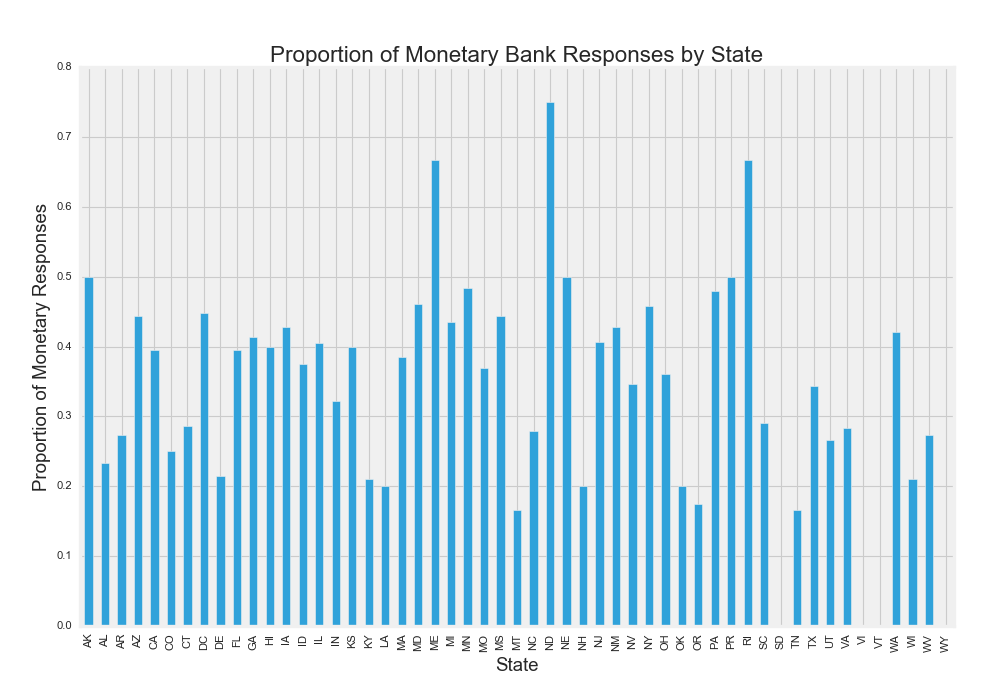

In [349]:
sortedProportion= proportionMonetary.copy()
sortedProportion['Company response to consumer'].plot(kind= 'bar', sort_columns= True)
plt.title('Proportion of Monetary Bank Responses by State')
plt.ylabel('Proportion of Monetary Responses')